In [1]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

In [2]:
tickers = ["GOOGL","WMT","BAC","NKE"]

In [3]:
def get_data(tickers,start="2017-01-01", end="2018-12-31") :
    prices = []
    for ticker in tickers :
        price = pdr.get_data_yahoo(ticker, start, end)["Open"]
        prices.append(price)
    prices = pd.concat(prices, axis=1)

    returns = prices.pct_change()

    prices.columns = pd.MultiIndex.from_tuples([("Prices",ticker) for ticker in tickers])
    returns.columns = pd.MultiIndex.from_tuples([("Returns",ticker) for ticker in tickers])

    data = pd.concat([prices, returns], axis=1)
    
    return data

In [9]:
data = get_data(tickers)
returns = data["Returns"]

In [6]:
def get_6month_returns(returns,date):
    range_max = date
    range_min = range_max - pd.DateOffset(months=6)
    return returns[range_min:range_max]

In [7]:
def optimize_portfolio(returns, nb_returns):
    V = returns.cov()

    w0 = np.repeat(1/nb_returns, nb_returns)

    def diversification_ratio(w):
        w_vol = np.dot(w.T, np.sqrt(np.diag(V)))

        port_vol = np.sqrt(np.dot(np.dot(w.T, V), w))

        diversification_ratio = w_vol/port_vol

        return -diversification_ratio

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    bnds = ((0, 1),)*nb_returns

    optimized = opt.minimize(diversification_ratio, w0, method='SLSQP', bounds=bnds, constraints=cons)

    return optimized

In [19]:
start_date = returns.index[0] + pd.DateOffset(months=6)
end_date = returns.index[-1]
iterations = (end_date.year - start_date.year)*12 + (end_date.month - start_date.month) + 1
nb_returns = len(tickers)
weights = pd.DataFrame([]).reindex_like(returns)[start_date:]
date = start_date
for i in range(iterations) :
    past_returns = get_6month_returns(returns, date)
    optimized = optimize_portfolio(past_returns, nb_returns)
    w = optimized.x
    newdate = date + pd.DateOffset(months=1)
    for j in range(nb_returns) :
        weights[weights.columns[j]][date:newdate] = w[j]
    date = newdate

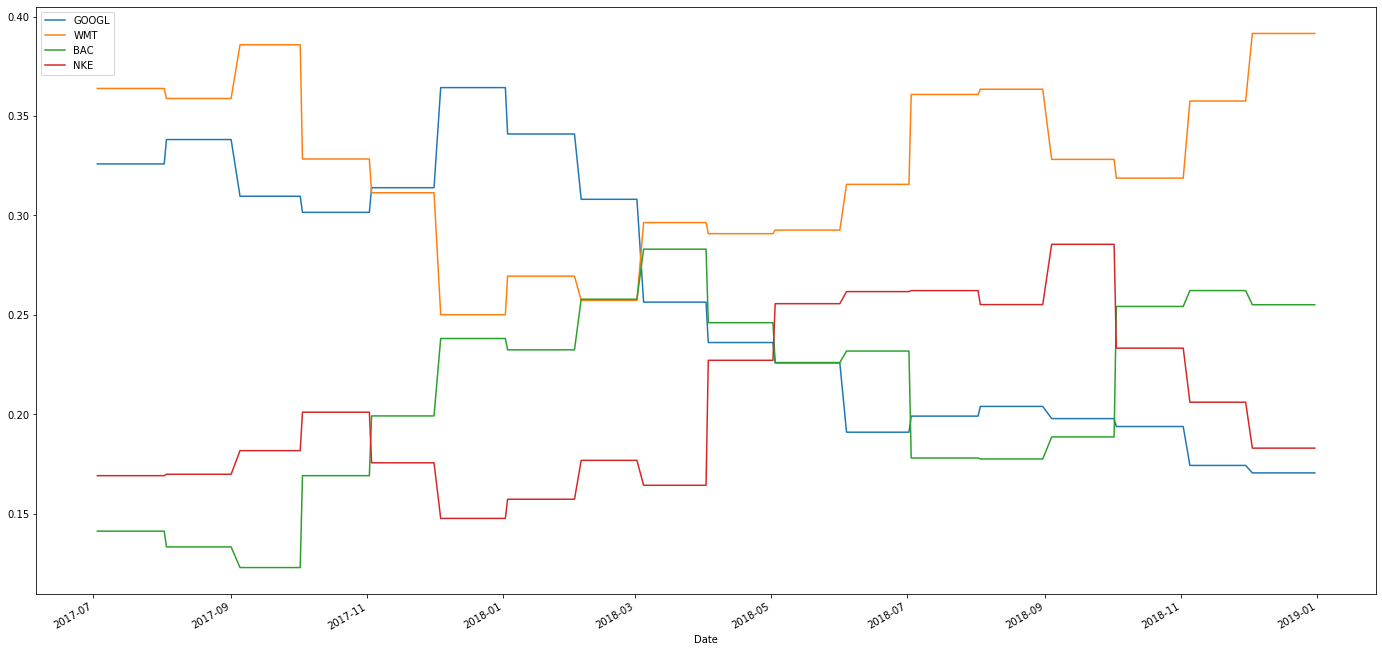

In [20]:
weights.plot(figsize=(24,12))

In [85]:
# portfolio_return = (weights*returns[start_date:]).sum(axis=1))
# portfolio_return.column = [["Portfolio"]]
portfolio_return = pd.DataFrame((weights*returns[start_date:]).sum(axis=1))
portfolio_return.columns = ["Portfolio"]
portfolio_cumreturn = (1+portfolio_return).cumprod()

In [86]:
cumreturns = (1+returns[start_date:]).cumprod()

In [87]:
new_returns = pd.concat([cumreturns,portfolio_cumreturn], axis=1)

In [88]:
new_returns

,GOOGL,WMT,BAC,NKE,Portfolio
Date,,,,,
2017-07-03,0.988591,0.996845,0.993501,1.031272,0.999505
2017-07-05,0.979036,0.993034,1.007311,1.028975,0.996552
2017-07-06,0.979883,0.990405,1.011373,1.015018,0.994155
2017-07-07,0.986229,0.994348,1.012185,1.014134,0.997659
2017-07-10,0.997839,0.987776,1.004062,1.022792,0.999397
...,...,...,...,...,...
2018-12-24,1.042723,1.137487,0.924452,1.261484,1.115992
2018-12-26,1.057204,1.135910,0.930544,1.213781,1.112184
2018-12-27,1.087088,1.179679,0.965881,1.275265,1.155401


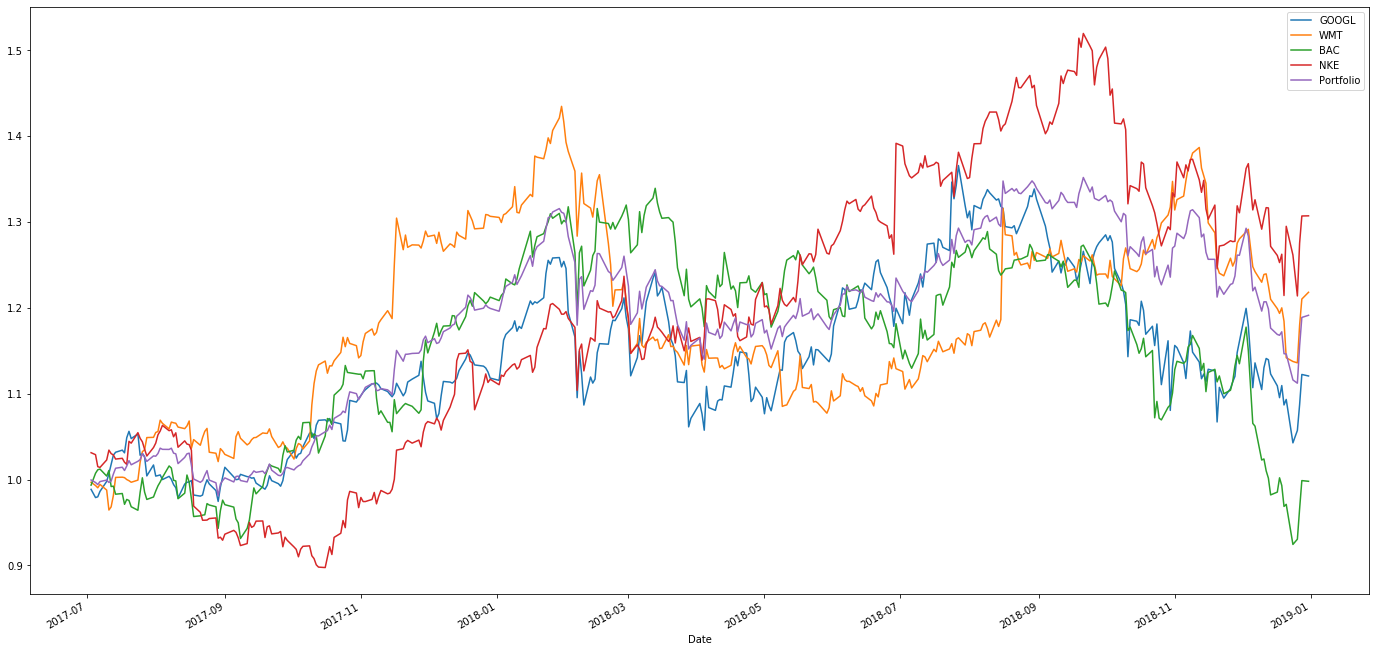

In [90]:
new_returns.plot(figsize=(24,12))